# Notebook Experimentations

In [13]:
import modin.pandas as pd
sales = pd.read_csv("./data/sales_train_validation.csv")
calender =pd.read_csv("./data/calendar.csv")

In [14]:
from transformer.DataAggregator import DataAggregator

data_aggregator = DataAggregator(sales)
aggregated_data = data_aggregator.aggregate(["store_id","dept_id"],"sum")
aggregated_data=aggregated_data.reset_index()
aggregated_data.head()

,store_id,dept_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,CA_1,FOODS_1,297,284,214,175,182,191,224,263,...,293,317,268,302,237,287,297,331,419,329
1,CA_1,FOODS_2,674,655,396,476,354,486,554,747,...,435,499,637,529,391,423,365,489,590,734
2,CA_1,FOODS_3,2268,2198,1398,1607,1496,1730,1915,2952,...,1978,2665,3099,2055,1860,1780,1871,2140,2646,2990
3,CA_1,HOBBIES_1,528,489,409,383,263,453,339,750,...,370,690,597,517,461,333,380,471,621,641
4,CA_1,HOBBIES_2,28,9,6,9,5,14,7,19,...,31,32,58,25,34,30,30,56,49,73


In [15]:
aggregated_data['store_dept_id'] = aggregated_data['store_id'].str.cat(aggregated_data['dept_id'], sep='_')
aggregated_data.drop(columns=['dept_id','store_id'],axis=1, inplace=True) # Drop the unnecessary columns
data = aggregated_data.T  # seting the days as index for new dataframe(Data)
data.columns = aggregated_data['store_dept_id'] # ading product id column to Data 
data.index.name = None   # remove the name of index
data.drop(index='store_dept_id',inplace=True) # remove the first row
# change the format and the freq. of index to datetime format
data.index = calender['date'][0:1913]
# data.index = pd.to_datetime(data.index)
data.index = data.index
data.index.freq= 'd'
data.head()

,CA_1_FOODS_1,CA_1_FOODS_2,CA_1_FOODS_3,CA_1_HOBBIES_1,CA_1_HOBBIES_2,CA_1_HOUSEHOLD_1,CA_1_HOUSEHOLD_2,CA_2_FOODS_1,CA_2_FOODS_2,CA_2_FOODS_3,...,WI_2_HOBBIES_2,WI_2_HOUSEHOLD_1,WI_2_HOUSEHOLD_2,WI_3_FOODS_1,WI_3_FOODS_2,WI_3_FOODS_3,WI_3_HOBBIES_1,WI_3_HOBBIES_2,WI_3_HOUSEHOLD_1,WI_3_HOUSEHOLD_2
2011-01-29,297,674,2268,528,28,361,181,406,212,1575,...,10,353,98,152,583,2293,256,22,584,148
2011-01-30,284,655,2198,489,9,350,170,408,227,1286,...,7,268,94,138,585,2383,342,14,541,195
2011-01-31,214,396,1398,409,6,279,114,238,138,913,...,18,250,69,127,575,1841,228,20,420,106
2011-02-01,175,476,1607,383,9,278,123,240,174,1126,...,15,305,80,98,533,1965,183,11,327,94
2011-02-02,182,354,1496,263,5,195,135,220,102,956,...,1,118,32,87,340,1427,70,4,151,53


In [16]:
data_ = pd.DataFrame()
data_['CA_1_FOODS_1'] = data['CA_1_FOODS_1']
# data_=data_.reset_index(drop=True)
# data_.rename(columns={"date":"ds","CA_1_FOODS_1":"y"},inplace=True)
# print(data_.dtypes)
data_.head()

,CA_1_FOODS_1
2011-01-29,297
2011-01-30,284
2011-01-31,214
2011-02-01,175
2011-02-02,182


In [17]:
train_data_ = data_[data_.index <= "2015-03-08"]
train_data_

,CA_1_FOODS_1
2011-01-29,297
2011-01-30,284
2011-01-31,214
2011-02-01,175
2011-02-02,182
...,...
2015-03-04,230
2015-03-05,334
2015-03-06,315
2015-03-07,396


In [18]:
test_data_ = data_[data_.index >= '2015-03-09']
test_data_ = test_data_[test_data_.index <= '2016-04-24']
test_data_

,CA_1_FOODS_1
2015-03-09,250
2015-03-10,227
2015-03-11,303
2015-03-12,275
2015-03-13,348
...,...
2016-04-20,287
2016-04-21,297
2016-04-22,331
2016-04-23,419


In [19]:
import xgboost as xgb
# dtrain = xgb.DMatrix(data_["ds"], label=data_["y"])

target_variable = "CA_1_FOODS_1"

timestamp_col = data_.index

target_sequence_length = 1*24

test_size = 0.30

hyperparameters = {
    "in_length" : 7*24,
    "step_size" : 12,
    "n_estimators" : 20,
    "max_depth" : 6,
    "subsample" : 0.5,
    "min_child_weight" : 1,
    "selected_features" : [target_variable]
    }

In [20]:
import utils
import numpy as np

training_indices = utils.get_indices_entire_sequence(
    data=train_data_, 
    window_size=hyperparameters["in_length"]+target_sequence_length, 
    step_size=hyperparameters["step_size"]
    )

# Obtain (X,Y) pairs of training data
x_train, y_train = utils.get_xgboost_x_y(
    indices=training_indices, 
    data=train_data_[hyperparameters["selected_features"]].to_numpy(),
    target_sequence_length=target_sequence_length,
    input_seq_len=hyperparameters["in_length"]
    )

test_indices = utils.get_indices_entire_sequence(
    data=test_data_, 
    window_size=hyperparameters["in_length"]+target_sequence_length, 
    step_size=24
    )

# Obtain (X,Y) pairs of test data
x_test, y_test = utils.get_xgboost_x_y(
    indices=test_indices, 
    data=test_data_[hyperparameters["selected_features"]].to_numpy(),
    target_sequence_length=target_sequence_length,
    input_seq_len=hyperparameters["in_length"]
    )

Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!


In [ ]:
from sklearn.multioutput import MultiOutputRegressor
model = xgb.XGBRegressor(
    n_estimators=hyperparameters["n_estimators"],
    max_depth=hyperparameters["max_depth"],
    subsample=hyperparameters["subsample"],
    min_child_weight=hyperparameters["min_child_weight"],
    objective="reg:squarederror",
    tree_method="hist"
    )

trained_model = MultiOutputRegressor(model).fit(x_train, y_train)

train_forecasts = trained_model.predict(x_train)

In [ ]:
# train_forecasts

In [ ]:
from sklearn.metrics import mean_absolute_error
test_forecasts = trained_model.predict(x_test)
test_mae = mean_absolute_error(y_test, test_forecasts)
print(f'Test MAE: { test_mae}')
print("Mean test data value: {}".format(np.mean(y_test)))

In [ ]:
import matplotlib.pyplot as plt
fontsize = 16
plot_df = pd.DataFrame({"Forecasts" : test_forecasts.flatten(), "Targets" : y_test.flatten()}, index=range(len(y_test.flatten())))

fig = plt.figure(figsize=(20,12))
plt.plot(plot_df.index, plot_df["Forecasts"].rolling(3).mean(), label="Forecasts")
plt.plot(plot_df.index, plot_df["Targets"].rolling(3).mean(), label="Targets")

plt.xlabel('Time', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("Unit sales", fontsize=fontsize)
plt.grid(True)
plt.legend(fontsize=fontsize)
plt.tight_layout()

# Driver

## data loading

In [1]:
import modin.pandas as pd
sales = pd.read_csv("./data/sales_train_validation.csv")
calender =pd.read_csv("./data/calendar.csv")

To remove this warning, run the following python code before doing dataframe operations:

    from distributed import Client

    client = Client()

Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.


In [2]:
sales['store_id'].unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

## data aggregation

In [3]:
from transformer.DataAggregator import DataAggregator
data_aggregator = DataAggregator(sales)
aggregated_data = data_aggregator.aggregate(["store_id","dept_id"],"sum")
aggregated_data=aggregated_data.reset_index()
aggregated_data.head()

,store_id,dept_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,CA_1,FOODS_1,297,284,214,175,182,191,224,263,...,293,317,268,302,237,287,297,331,419,329
1,CA_1,FOODS_2,674,655,396,476,354,486,554,747,...,435,499,637,529,391,423,365,489,590,734
2,CA_1,FOODS_3,2268,2198,1398,1607,1496,1730,1915,2952,...,1978,2665,3099,2055,1860,1780,1871,2140,2646,2990
3,CA_1,HOBBIES_1,528,489,409,383,263,453,339,750,...,370,690,597,517,461,333,380,471,621,641
4,CA_1,HOBBIES_2,28,9,6,9,5,14,7,19,...,31,32,58,25,34,30,30,56,49,73


## data Cleaning

In [4]:
aggregated_data['store_dept_id'] = aggregated_data['store_id'].str.cat(aggregated_data['dept_id'], sep='_')
aggregated_data.drop(columns=['dept_id','store_id'],axis=1, inplace=True) # Drop the unnecessary columns
data = aggregated_data.T  # seting the days as index for new dataframe(Data)
data.columns = aggregated_data['store_dept_id'] # ading product id column to Data 
data.index.name = None   # remove the name of index
data.drop(index='store_dept_id',inplace=True) # remove the first row
# change the format and the freq. of index to datetime format
data.index = calender['date'][0:1913]
# data.index = pd.to_datetime(data.index)
data.index = data.index
data.index.freq= 'd'
data.head()

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


,CA_1_FOODS_1,CA_1_FOODS_2,CA_1_FOODS_3,CA_1_HOBBIES_1,CA_1_HOBBIES_2,CA_1_HOUSEHOLD_1,CA_1_HOUSEHOLD_2,CA_2_FOODS_1,CA_2_FOODS_2,CA_2_FOODS_3,...,WI_2_HOBBIES_2,WI_2_HOUSEHOLD_1,WI_2_HOUSEHOLD_2,WI_3_FOODS_1,WI_3_FOODS_2,WI_3_FOODS_3,WI_3_HOBBIES_1,WI_3_HOBBIES_2,WI_3_HOUSEHOLD_1,WI_3_HOUSEHOLD_2
2011-01-29,297,674,2268,528,28,361,181,406,212,1575,...,10,353,98,152,583,2293,256,22,584,148
2011-01-30,284,655,2198,489,9,350,170,408,227,1286,...,7,268,94,138,585,2383,342,14,541,195
2011-01-31,214,396,1398,409,6,279,114,238,138,913,...,18,250,69,127,575,1841,228,20,420,106
2011-02-01,175,476,1607,383,9,278,123,240,174,1126,...,15,305,80,98,533,1965,183,11,327,94
2011-02-02,182,354,1496,263,5,195,135,220,102,956,...,1,118,32,87,340,1427,70,4,151,53


## data spliting

In [5]:
from transformer.TrainTestSplit import TrainTestSplit
tts = TrainTestSplit( data, test_size=0.3, random_state=0,shuffle=False)
X_train_, X_test_, y_train_, y_test_ = tts.split_data()

In [6]:
X_train_

Index(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01', '2011-02-02',
       '2011-02-03', '2011-02-04', '2011-02-05', '2011-02-06', '2011-02-07',
       ...
       '2014-09-19', '2014-09-20', '2014-09-21', '2014-09-22', '2014-09-23',
       '2014-09-24', '2014-09-25', '2014-09-26', '2014-09-27', '2014-09-28'],
      dtype='object', length=1339)

In [7]:
y_train_.columns

Index(['CA_1_FOODS_1', 'CA_1_FOODS_2', 'CA_1_FOODS_3', 'CA_1_HOBBIES_1',
       'CA_1_HOBBIES_2', 'CA_1_HOUSEHOLD_1', 'CA_1_HOUSEHOLD_2',
       'CA_2_FOODS_1', 'CA_2_FOODS_2', 'CA_2_FOODS_3', 'CA_2_HOBBIES_1',
       'CA_2_HOBBIES_2', 'CA_2_HOUSEHOLD_1', 'CA_2_HOUSEHOLD_2',
       'CA_3_FOODS_1', 'CA_3_FOODS_2', 'CA_3_FOODS_3', 'CA_3_HOBBIES_1',
       'CA_3_HOBBIES_2', 'CA_3_HOUSEHOLD_1', 'CA_3_HOUSEHOLD_2',
       'CA_4_FOODS_1', 'CA_4_FOODS_2', 'CA_4_FOODS_3', 'CA_4_HOBBIES_1',
       'CA_4_HOBBIES_2', 'CA_4_HOUSEHOLD_1', 'CA_4_HOUSEHOLD_2',
       'TX_1_FOODS_1', 'TX_1_FOODS_2', 'TX_1_FOODS_3', 'TX_1_HOBBIES_1',
       'TX_1_HOBBIES_2', 'TX_1_HOUSEHOLD_1', 'TX_1_HOUSEHOLD_2',
       'TX_2_FOODS_1', 'TX_2_FOODS_2', 'TX_2_FOODS_3', 'TX_2_HOBBIES_1',
       'TX_2_HOBBIES_2', 'TX_2_HOUSEHOLD_1', 'TX_2_HOUSEHOLD_2',
       'TX_3_FOODS_1', 'TX_3_FOODS_2', 'TX_3_FOODS_3', 'TX_3_HOBBIES_1',
       'TX_3_HOBBIES_2', 'TX_3_HOUSEHOLD_1', 'TX_3_HOUSEHOLD_2',
       'WI_1_FOODS_1', 'WI_1_FOODS

## Formating the data and modeling

In [11]:
import utils
import numpy as np
import xgboost as xgb
trained_model={}
timestamp_col = data.index

target_sequence_length = 1*24

test_size = 0.30

hyperparameters = {
    "in_length" : 7*24,
    "step_size" : 12,
    "n_estimators" : 20,
    "max_depth" : 6,
    "subsample" : 0.5,
    "min_child_weight" : 1,
    }

for i in data.columns:
    y_train_data_ = pd.DataFrame()
    y_test_data_ = pd.DataFrame()
    y_train_data_[i] = y_train_[i]
    y_test_data_[i] = y_test_[i]
    training_indices = utils.get_indices_entire_sequence(
        data=y_train_data_, 
        window_size=hyperparameters["in_length"]+target_sequence_length, 
        step_size=hyperparameters["step_size"]
        )

    # Obtain (X,Y) pairs of training data
    x_train, y_train = utils.get_xgboost_x_y(
        indices=training_indices, 
        data=y_train_data_.to_numpy(),
        target_sequence_length=target_sequence_length,
        input_seq_len=hyperparameters["in_length"]
        )

    test_indices = utils.get_indices_entire_sequence(
        data=y_test_data_, 
        window_size=hyperparameters["in_length"]+target_sequence_length, 
        step_size=24
        )

    # Obtain (X,Y) pairs of test data
    x_test, y_test = utils.get_xgboost_x_y(
        indices=test_indices, 
        data=y_test_data_.to_numpy(),
        target_sequence_length=target_sequence_length,
        input_seq_len=hyperparameters["in_length"]
        )
    from sklearn.multioutput import MultiOutputRegressor
    model = xgb.XGBRegressor(
        n_estimators=hyperparameters["n_estimators"],
        max_depth=hyperparameters["max_depth"],
        subsample=hyperparameters["subsample"],
        min_child_weight=hyperparameters["min_child_weight"],
        objective="reg:squarederror",
        tree_method="hist"
        )

    trained_model["model_{0}".format(i)] = MultiOutputRegressor(model).fit(x_train, y_train)
    # print(trained_model)
    train_forecasts = trained_model["model_{0}".format(i)].predict(x_train)
    from sklearn.metrics import mean_absolute_error
    test_forecasts = trained_model["model_{0}".format(i)].predict(x_test)
    test_mae = mean_absolute_error(y_test, test_forecasts)
    print(f'Test MAE: { test_mae}')
    print("Mean test data value: {}".format(np.mean(y_test)))

Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 67.80898922681808
Mean test data value: 333.1458333333333


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 80.93581302960713
Mean test data value: 503.1875


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 261.41521231333417
Mean test data value: 2051.1666666666665
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 84.48689079284668
Mean test data value: 499.1041666666667
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 17.73630839710434
Mean test data value: 43.893229166666664


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 129.57990618546805
Mean test data value: 780.0416666666666
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 38.375335762898125
Mean test data value: 211.45572916666666


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 78.78576664129893
Mean test data value: 398.390625


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 253.95413015782833
Mean test data value: 366.1458333333333


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 370.13933142026264
Mean test data value: 1542.4583333333333


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 66.42930869261424
Mean test data value: 342.6145833333333


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 16.387692014376324
Mean test data value: 43.4453125
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 110.08090031147003
Mean test data value: 703.6145833333334
Preparing data..
Finished preparing data!


Preparing data..
Finished preparing data!
Test MAE: 53.880757788817085
Mean test data value: 289.828125


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 83.22349882125854
Mean test data value: 430.9869791666667


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 82.25276176134746
Mean test data value: 662.7604166666666


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 376.3506841659546
Mean test data value: 2833.9140625
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 96.14024496078491
Mean test data value: 547.4635416666666


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 23.468417738874752
Mean test data value: 58.572916666666664


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 210.2969607512156
Mean test data value: 1418.5885416666667
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 45.19306447108587
Mean test data value: 317.65625
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 48.92010066906611
Mean test data value: 222.3515625


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 60.82829360167185
Mean test data value: 330.4635416666667


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 124.63260650634766
Mean test data value: 1022.7864583333334
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 74.90024360020955
Mean test data value: 363.1302083333333
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 7.903487693828841
Mean test data value: 18.161458333333332
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 59.42854845523834
Mean test data value: 364.1197916666667


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 22.959202334284782
Mean test data value: 121.72395833333333


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 50.453230599562325
Mean test data value: 229.9140625


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 51.99740139643351
Mean test data value: 356.8776041666667


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 199.80943711598715
Mean test data value: 1370.0052083333333


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 54.738193233807884
Mean test data value: 248.16666666666666


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 17.39718460974594
Mean test data value: 35.005208333333336


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 103.93726587295532
Mean test data value: 756.1692708333334


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 30.474444429079693
Mean test data value: 164.13541666666666


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 56.35350716114044
Mean test data value: 255.015625


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 59.068289478619896
Mean test data value: 416.0520833333333


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 273.78385829925537
Mean test data value: 1817.5078125


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 53.731966416041054
Mean test data value: 322.5885416666667


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 21.694316405802965
Mean test data value: 50.880208333333336
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 109.45552039146423
Mean test data value: 768.8567708333334


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 33.98211568593979
Mean test data value: 189.3671875
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 57.00501128037771
Mean test data value: 275.1432291666667


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 87.59812581539154
Mean test data value: 468.5911458333333
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 206.3808797200521
Mean test data value: 1641.609375


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 75.1839171051979
Mean test data value: 328.9609375


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 19.13029094785452
Mean test data value: 46.6328125
Preparing data..
Finished preparing data!


Preparing data..
Finished preparing data!
Test MAE: 157.60834630330405
Mean test data value: 815.0755208333334
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 25.66886196533839
Mean test data value: 156.34635416666666


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 70.93182688951492
Mean test data value: 311.6145833333333


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 174.42928699652353
Mean test data value: 561.7421875


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 216.59561745325723
Mean test data value: 1534.2005208333333


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 75.00593503316243
Mean test data value: 373.4010416666667


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 12.685486063361168
Mean test data value: 33.830729166666664


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 111.54622526963551
Mean test data value: 571.875


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 32.61820571621259
Mean test data value: 154.734375


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 67.52526775995891
Mean test data value: 328.3229166666667


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 247.78743131955466
Mean test data value: 856.3020833333334


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 310.2177168528239
Mean test data value: 1878.4817708333333


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 44.38562877972921
Mean test data value: 218.74479166666666


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 12.058024168014526
Mean test data value: 30.205729166666668


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 214.32530053456625
Mean test data value: 898.9869791666666


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 22.438581069310505
Mean test data value: 123.8984375


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 51.297122617562614
Mean test data value: 251.15104166666666


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 81.95666734377544
Mean test data value: 443.7291666666667


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 274.9648796717326
Mean test data value: 1722.859375
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 46.27199226617813
Mean test data value: 231.56510416666666
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 11.831193671872219
Mean test data value: 28.356770833333332
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 97.06737192471822
Mean test data value: 620.5390625
Preparing data..
Finished preparing data!


Preparing data..
Finished preparing data!
Test MAE: 26.233857442935307
Mean test data value: 130.07552083333334


In [15]:

trained_model['model_CA_1_HOBBIES_2']

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                      

# Hyperopt integration

## experimentations

In [1]:
import modin.pandas as pd
sales = pd.read_csv("./data/sales_train_validation.csv")
calender =pd.read_csv("./data/calendar.csv")
from transformer.DataAggregator import DataAggregator

data_aggregator = DataAggregator(sales)
aggregated_data = data_aggregator.aggregate(["store_id","dept_id"],"sum")
aggregated_data=aggregated_data.reset_index()
aggregated_data.head()
aggregated_data['store_dept_id'] = aggregated_data['store_id'].str.cat(aggregated_data['dept_id'], sep='_')
aggregated_data.drop(columns=['dept_id','store_id'],axis=1, inplace=True) # Drop the unnecessary columns
data = aggregated_data.T  # seting the days as index for new dataframe(Data)
data.columns = aggregated_data['store_dept_id'] # ading product id column to Data 
data.index.name = None   # remove the name of index
data.drop(index='store_dept_id',inplace=True) # remove the first row
# change the format and the freq. of index to datetime format
data.index = calender['date'][0:1913]
# data.index = pd.to_datetime(data.index)
data.index = data.index
data.index.freq= 'd'
data.head()
data_ = pd.DataFrame()
data_['CA_1_FOODS_1'] = data['CA_1_FOODS_1']
data_.head()
train_data_ = data_[data_.index <= "2015-03-08"]
train_data_
test_data_ = data_[data_.index >= '2015-03-09']
test_data_ = test_data_[test_data_.index <= '2016-04-24']
test_data_
import xgboost as xgb

target_variable = "CA_1_FOODS_1"

timestamp_col = data_.index

target_sequence_length = 1*24

test_size = 0.30

hyperparameters = {
    "in_length" : 7*24,
    "step_size" : 12,
    "n_estimators" : 20,
    "max_depth" : 6,
    "subsample" : 0.5,
    "min_child_weight" : 1,
    "selected_features" : [target_variable]
    }
import utils
import numpy as np

training_indices = utils.get_indices_entire_sequence(
    data=train_data_, 
    window_size=hyperparameters["in_length"]+target_sequence_length, 
    step_size=hyperparameters["step_size"]
    )

# Obtain (X,Y) pairs of training data
x_train, y_train = utils.get_xgboost_x_y(
    indices=training_indices, 
    data=train_data_[hyperparameters["selected_features"]].to_numpy(),
    target_sequence_length=target_sequence_length,
    input_seq_len=hyperparameters["in_length"]
    )

test_indices = utils.get_indices_entire_sequence(
    data=test_data_, 
    window_size=hyperparameters["in_length"]+target_sequence_length, 
    step_size=24
    )

# Obtain (X,Y) pairs of test data
x_test, y_test = utils.get_xgboost_x_y(
    indices=test_indices, 
    data=test_data_[hyperparameters["selected_features"]].to_numpy(),
    target_sequence_length=target_sequence_length,
    input_seq_len=hyperparameters["in_length"]
    )
from sklearn.multioutput import MultiOutputRegressor
model = xgb.XGBRegressor(
    n_estimators=hyperparameters["n_estimators"],
    max_depth=hyperparameters["max_depth"],
    subsample=hyperparameters["subsample"],
    min_child_weight=hyperparameters["min_child_weight"],
    objective="reg:squarederror",
    tree_method="hist"
    )

trained_model = MultiOutputRegressor(model).fit(x_train, y_train)

train_forecasts = trained_model.predict(x_train)
from sklearn.metrics import mean_absolute_error
test_forecasts = trained_model.predict(x_test)
test_mae = mean_absolute_error(y_test, test_forecasts)
print(f'Test MAE: { test_mae}')
print("Mean test data value: {}".format(np.mean(y_test)))

To remove this warning, run the following python code before doing dataframe operations:

    from distributed import Client

    client = Client()

Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.
Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
Test MAE: 73.77700967788697
Mean test data value: 299.59583333333336


In [6]:
from hyperopt import fmin, tpe, hp, STATUS_OK
from sklearn.metrics import mean_absolute_error
space = {
    'n_estimators': hp.choice('n_estimators', range(100, 300)),
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'learning_rate': hp.loguniform('learning_rate', -4, 0),
    'subsample': hp.uniform('subsample', 0.1, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# define objective function to be optimized by Hyperopt
def objective(params):
    xgb_regressor = xgb.XGBRegressor(**params)
    xgb_regressor = MultiOutputRegressor(xgb_regressor)
    xgb_regressor.fit(x_train, y_train)
    y_pred = xgb_regressor.predict(x_test)
    mse = mean_absolute_error(y_test, y_pred)
    return {'loss': mse, 'status': STATUS_OK}

# optimize hyperparameters using Hyperopt's Tree-structured Parzen Estimator (TPE) algorithm
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20)

print(best)


100%|██████████| 20/20 [21:58<00:00, 65.93s/trial, best loss: 64.56682173411052] 
{'gamma': 0.37686957643707664, 'learning_rate': 0.05388730070170305, 'max_depth': 4, 'n_estimators': 333, 'reg_alpha': 0.1025975933446539, 'reg_lambda': 0.8142603073602603, 'subsample': 0.808020589285609}


In [8]:
from sklearn.multioutput import MultiOutputRegressor
model = xgb.XGBRegressor(
    gamma= 0.37686957643707664,
    learning_rate= 0.05388730070170305,
    max_depth= 4,
    n_estimators= 333,
    reg_alpha= 0.1025975933446539,
    reg_lambda= 0.8142603073602603, 
    subsample= 0.808020589285609
    )
trained_model = MultiOutputRegressor(model).fit(x_train, y_train)

In [9]:


train_forecasts = trained_model.predict(x_train)
from sklearn.metrics import mean_absolute_error
test_forecasts = trained_model.predict(x_test)
test_mae = mean_absolute_error(y_test, test_forecasts)
print(f'Test MAE: { test_mae}')
print("Mean test data value: {}".format(np.mean(y_test)))

Test MAE: 65.17079226175944
Mean test data value: 299.59583333333336


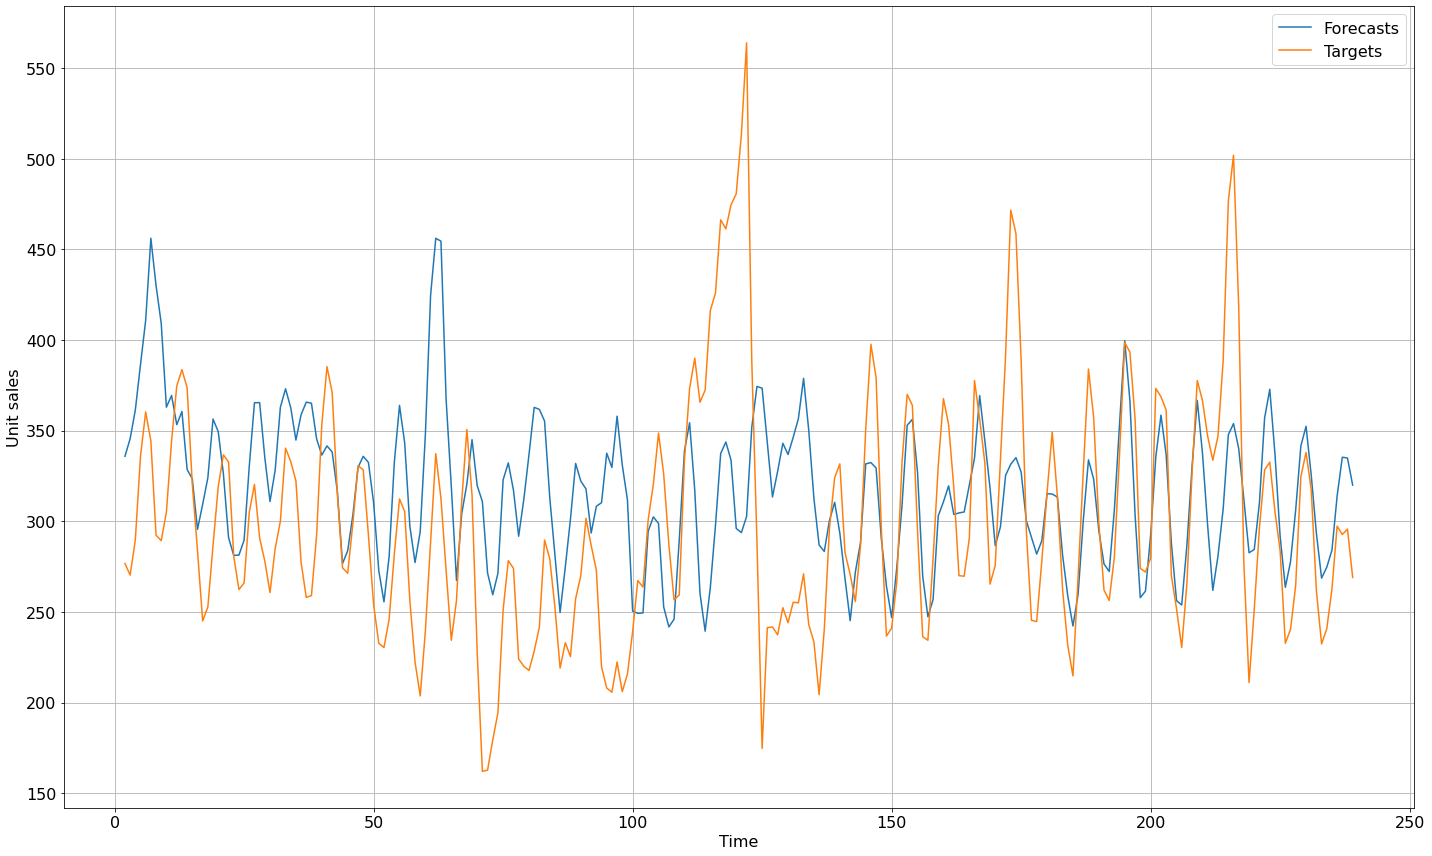

In [10]:
import matplotlib.pyplot as plt
fontsize = 16
plot_df = pd.DataFrame({"Forecasts" : test_forecasts.flatten(), "Targets" : y_test.flatten()}, index=range(len(y_test.flatten())))

fig = plt.figure(figsize=(20,12))
plt.plot(plot_df.index, plot_df["Forecasts"].rolling(3).mean(), label="Forecasts")
plt.plot(plot_df.index, plot_df["Targets"].rolling(3).mean(), label="Targets")

plt.xlabel('Time', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("Unit sales", fontsize=fontsize)
plt.grid(True)
plt.legend(fontsize=fontsize)
plt.tight_layout()

# driver with hyperopt hyperparameter tuning

In [1]:
import modin.pandas as pd
sales = pd.read_csv("./data/sales_train_validation.csv")
calender =pd.read_csv("./data/calendar.csv")
from transformer.DataAggregator import DataAggregator
data_aggregator = DataAggregator(sales)
aggregated_data = data_aggregator.aggregate(["store_id","dept_id"],"sum")
aggregated_data=aggregated_data.reset_index()
aggregated_data.head()
aggregated_data['store_dept_id'] = aggregated_data['store_id'].str.cat(aggregated_data['dept_id'], sep='_')
aggregated_data.drop(columns=['dept_id','store_id'],axis=1, inplace=True) # Drop the unnecessary columns
data = aggregated_data.T  # seting the days as index for new dataframe(Data)
data.columns = aggregated_data['store_dept_id'] # ading product id column to Data 
data.index.name = None   # remove the name of index
data.drop(index='store_dept_id',inplace=True) # remove the first row
# change the format and the freq. of index to datetime format
data.index = calender['date'][0:1913]
# data.index = pd.to_datetime(data.index)
data.index = data.index
data.index.freq= 'd'
data.head()
from transformer.TrainTestSplit import TrainTestSplit
tts = TrainTestSplit( data, test_size=0.3, random_state=0,shuffle=False)
X_train_, X_test_, y_train_, y_test_ = tts.split_data()
import utils
import numpy as np
import xgboost as xgb
trained_model={}
timestamp_col = data.index

target_sequence_length = 1*24

test_size = 0.30

hyperparameters = {
    "in_length" : 7*24,
    "step_size" : 12,
    "n_estimators" : 20,
    "max_depth" : 6,
    "subsample" : 0.5,
    "min_child_weight" : 1,
    }






To remove this warning, run the following python code before doing dataframe operations:

    from distributed import Client

    client = Client()

Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.
Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


In [2]:
from hyperopt import fmin, tpe, hp, STATUS_OK
from sklearn.metrics import mean_absolute_error
space = {
    'n_estimators': hp.choice('n_estimators', range(100, 300)),
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'learning_rate': hp.loguniform('learning_rate', -4, 0),
    'subsample': hp.uniform('subsample', 0.1, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

In [6]:
trained_model={}
best ={}

for i in data.columns:
    y_train_data_ = pd.DataFrame()
    y_test_data_ = pd.DataFrame()
    y_train_data_[i] = y_train_[i]
    y_test_data_[i] = y_test_[i]
    training_indices = utils.get_indices_entire_sequence(
        data=y_train_data_, 
        window_size=hyperparameters["in_length"]+target_sequence_length, 
        step_size=hyperparameters["step_size"]
        )

    # Obtain (X,Y) pairs of training data
    x_train, y_train = utils.get_xgboost_x_y(
        indices=training_indices, 
        data=y_train_data_.to_numpy(),
        target_sequence_length=target_sequence_length,
        input_seq_len=hyperparameters["in_length"]
        )

    test_indices = utils.get_indices_entire_sequence(
        data=y_test_data_, 
        window_size=hyperparameters["in_length"]+target_sequence_length, 
        step_size=24
        )

    # Obtain (X,Y) pairs of test data
    x_test, y_test = utils.get_xgboost_x_y(
        indices=test_indices, 
        data=y_test_data_.to_numpy(),
        target_sequence_length=target_sequence_length,
        input_seq_len=hyperparameters["in_length"]
        )
    from sklearn.multioutput import MultiOutputRegressor
    def objective(params):
        model = xgb.XGBRegressor(**params)
        trained_model["model_{0}".format(i)] = MultiOutputRegressor(model).fit(x_train, y_train)
        # train_forecasts = trained_model["model_{0}".format(i)].predict(x_train)
        test_forecasts = trained_model["model_{0}".format(i)].predict(x_test)
        mse = mean_absolute_error(y_test, test_forecasts)
        # print(f'Test MAE: { mse}')
        # print("Mean test data value: {}".format(np.mean(y_test)))
        return {'loss': mse, 'status': STATUS_OK}

    # optimize hyperparameters using Hyperopt's Tree-structured Parzen Estimator (TPE) algorithm
    best["best_param_{0}".format(i)] = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=2)

    print(best["best_param_{0}".format(i)])

    

Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:23<00:00, 11.52s/trial, best loss: 66.80683042605718]
{'gamma': 0.053543859402459315, 'learning_rate': 0.43304389079434624, 'max_depth': 15, 'n_estimators': 72, 'reg_alpha': 0.26799495705671394, 'reg_lambda': 0.5463312802226415, 'subsample': 0.9902903738041059}
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:25<00:00, 12.92s/trial, best loss: 71.0442442893982]
{'gamma': 0.39940548830561096, 'learning_rate': 0.10848146700403224, 'max_depth': 3, 'n_estimators': 71, 'reg_alpha': 0.2558543873217455, 'reg_lambda': 0.24742950910202977, 'subsample': 0.8702714380403754}
Preparing data..
Finished preparing data!


Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:09<00:00,  4.98s/trial, best loss: 246.04540379842123]
{'gamma': 0.23364734907439333, 'learning_rate': 0.4177455435798207, 'max_depth': 1, 'n_estimators': 28, 'reg_alpha': 0.7496238759532141, 'reg_lambda': 0.7517304847459683, 'subsample': 0.7349313582894517}
Preparing data..
Finished preparing data!


Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:37<00:00, 18.66s/trial, best loss: 68.6009115378062]
{'gamma': 0.8265728193044771, 'learning_rate': 0.11396035787864638, 'max_depth': 17, 'n_estimators': 179, 'reg_alpha': 0.16830954584683033, 'reg_lambda': 0.09019395356464532, 'subsample': 0.4888276780212407}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:08<00:00,  4.04s/trial, best loss: 13.754679208000502]
{'gamma': 0.7262986627500678, 'learning_rate': 0.04144716262718234, 'max_depth': 10, 'n_estimators': 16, 'reg_alpha': 0.42132380109147705, 'reg_lambda': 0.16117276049809293, 'subsample': 0.20198719385660463}
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:10<00:00,  5.38s/trial, best loss: 128.41805744171143]
{'gamma': 0.24999176841299597, 'learning_rate': 0.029397113440706422, 'max_depth': 16, 'n_estimators': 10, 'reg_alpha': 0.5414668616557274, 'reg_lambda': 0.02112646770262272, 'subsample': 0.11926593032153363}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:06<00:00,  3.23s/trial, best loss: 33.24619843562444]
{'gamma': 0.2774451217334649, 'learning_rate': 0.054251730120375756, 'max_depth': 1, 'n_estimators': 37, 'reg_alpha': 0.7952990037140467, 'reg_lambda': 0.8556112135250712, 'subsample': 0.29129583462627384}
Preparing data..
Finished preparing data!


Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:37<00:00, 18.53s/trial, best loss: 65.6057870388031] 
{'gamma': 0.32870865011251804, 'learning_rate': 0.06921071366730816, 'max_depth': 11, 'n_estimators': 185, 'reg_alpha': 0.3166555851772149, 'reg_lambda': 0.0685182708903177, 'subsample': 0.7452160189455808}
Preparing data..
Finished preparing data!


Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:34<00:00, 17.44s/trial, best loss: 232.5943694661061] 
{'gamma': 0.2615554422378832, 'learning_rate': 0.07955383579846578, 'max_depth': 7, 'n_estimators': 163, 'reg_alpha': 0.594054664747561, 'reg_lambda': 0.1846585712692944, 'subsample': 0.9972699967263855}
Preparing data..
Finished preparing data!


Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:07<00:00,  3.84s/trial, best loss: 364.84593598047894]
{'gamma': 0.8505498954235057, 'learning_rate': 0.036553262144409834, 'max_depth': 6, 'n_estimators': 124, 'reg_alpha': 0.9409907673842194, 'reg_lambda': 0.3296269088049506, 'subsample': 0.1139290725014144}
Preparing data..
Finished preparing data!


Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:26<00:00, 13.38s/trial, best loss: 61.088444193204246]
{'gamma': 0.5170108521668275, 'learning_rate': 0.21622425493774075, 'max_depth': 2, 'n_estimators': 101, 'reg_alpha': 0.46524071431725367, 'reg_lambda': 0.2998684495937365, 'subsample': 0.9081350403581949}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:19<00:00,  9.54s/trial, best loss: 14.583786879976591]
{'gamma': 0.08531776516056899, 'learning_rate': 0.061784583119453264, 'max_depth': 11, 'n_estimators': 81, 'reg_alpha': 0.5898068961034453, 'reg_lambda': 0.20137721505095474, 'subsample': 0.6938462003799442}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:22<00:00, 11.43s/trial, best loss: 98.53319104512532]
{'gamma': 0.34675825933006665, 'learning_rate': 0.0563009142324978, 'max_depth': 3, 'n_estimators': 95, 'reg_alpha': 0.3044820544244443, 'reg_lambda': 0.26584648336476835, 'subsample': 0.830369743255019}
Preparing data..
Finished preparing data!
Preparing data..


Finished preparing data!
100%|██████████| 2/2 [00:22<00:00, 11.25s/trial, best loss: 48.355711460113525]
{'gamma': 0.3993985567333649, 'learning_rate': 0.13924421868634923, 'max_depth': 16, 'n_estimators': 139, 'reg_alpha': 0.4736133361577942, 'reg_lambda': 0.7591838295791231, 'subsample': 0.43940386414000654}
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:37<00:00, 18.50s/trial, best loss: 69.7945402065913]
{'gamma': 0.3767671763122483, 'learning_rate': 0.018597341343265492, 'max_depth': 5, 'n_estimators': 158, 'reg_alpha': 0.6135712859371205, 'reg_lambda': 0.23298862845859614, 'subsample': 0.4507933176116635}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:53<00:00, 26.81s/trial, best loss: 73.94307764371236]
{'gamma': 0.9514678407982908, 'learning_rate': 0.020300015015235384, 'max_depth': 8, 'n_estimators': 166, 'reg_alpha': 0.11285706571060761, 'reg_lambda': 0.21534847991348782, 'subsample': 0.22755922462563954}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:28<00:00, 14.34s/trial, best loss: 388.38586107889813]
{'gamma': 0.13042256596310142, 'learning_rate': 0.49586021849393336, 'max_depth': 0, 'n_estimators': 125, 'reg_alpha': 0.6847846710138374, 'reg_lambda': 0.60935906126537, 'subsample': 0.7134099887325015}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:39<00:00, 19.64s/trial, best loss: 79.38385605812073] 
{'gamma': 0.29130727283568447, 'learning_rate': 0.1515050810836505, 'max_depth': 2, 'n_estimators': 74, 'reg_alpha': 0.4959545172595179, 'reg_lambda': 0.33263463581217423, 'subsample': 0.7923334745192999}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:19<00:00,  9.71s/trial, best loss: 19.363019958138466]
{'gamma': 0.368742085067589, 'learning_rate': 0.10638271880055264, 'max_depth': 11, 'n_estimators': 179, 'reg_alpha': 0.8520944554662336, 'reg_lambda': 0.5727162201185204, 'subsample': 0.23749714039082997}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:18<00:00,  9.32s/trial, best loss: 171.46638464927673]
{'gamma': 0.9812318162437232, 'learning_rate': 0.07255719402070736, 'max_depth': 14, 'n_estimators': 6, 'reg_alpha': 0.5665208530862295, 'reg_lambda': 0.18748584886968966, 'subsample': 0.9202508282686575}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:42<00:00, 21.34s/trial, best loss: 42.73582057158152]
{'gamma': 0.7153313050829988, 'learning_rate': 0.24686431166138592, 'max_depth': 9, 'n_estimators': 96, 'reg_alpha': 0.535510072449222, 'reg_lambda': 0.9193373556303495, 'subsample': 0.6732236508031187}
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:29<00:00, 14.68s/trial, best loss: 41.080956200758614]
{'gamma': 0.4940152211448793, 'learning_rate': 0.03380647655547944, 'max_depth': 11, 'n_estimators': 86, 'reg_alpha': 0.7033322443240138, 'reg_lambda': 0.4777826945982707, 'subsample': 0.5615985230203211}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:25<00:00, 12.73s/trial, best loss: 53.89824388424555]
{'gamma': 0.9199678656598044, 'learning_rate': 0.05777681769818547, 'max_depth': 17, 'n_estimators': 52, 'reg_alpha': 0.4175496910005827, 'reg_lambda': 0.045587308221022416, 'subsample': 0.6883723104412715}
Preparing data..
Finished preparing data!


Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:40<00:00, 20.05s/trial, best loss: 105.05378246307373]
{'gamma': 0.7560769715806622, 'learning_rate': 0.01866535151684672, 'max_depth': 9, 'n_estimators': 96, 'reg_alpha': 0.5010759811288634, 'reg_lambda': 0.4705371021839465, 'subsample': 0.8323155895419808}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:27<00:00, 13.57s/trial, best loss: 67.10649804274242]
{'gamma': 0.623772962961201, 'learning_rate': 0.24789391206611894, 'max_depth': 3, 'n_estimators': 185, 'reg_alpha': 0.9567040683788055, 'reg_lambda': 0.10035088659845359, 'subsample': 0.6262498674609231}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:25<00:00, 12.95s/trial, best loss: 8.553807880729437]
{'gamma': 0.5563149138157784, 'learning_rate': 0.3668400622752904, 'max_depth': 4, 'n_estimators': 115, 'reg_alpha': 0.10020351485992252, 'reg_lambda': 0.9028051635941711, 'subsample': 0.6749128162861625}
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:31<00:00, 16.00s/trial, best loss: 54.45489877462387]
{'gamma': 0.7849397111284431, 'learning_rate': 0.08484694211632479, 'max_depth': 13, 'n_estimators': 155, 'reg_alpha': 0.04202734735935987, 'reg_lambda': 0.9394097819109559, 'subsample': 0.4172072920658534}
Preparing data..
Finished preparing data!


Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:14<00:00,  7.26s/trial, best loss: 18.59970085819562]
{'gamma': 0.421900302193285, 'learning_rate': 0.5134809363960335, 'max_depth': 0, 'n_estimators': 123, 'reg_alpha': 0.5259820901065835, 'reg_lambda': 0.5356121675201495, 'subsample': 0.8712943379097018}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:34<00:00, 17.04s/trial, best loss: 47.33245964845022]
{'gamma': 0.009656410006175231, 'learning_rate': 0.04256012049082152, 'max_depth': 8, 'n_estimators': 105, 'reg_alpha': 0.5072304562243048, 'reg_lambda': 0.7997949186374346, 'subsample': 0.7919289374392494}
Preparing data..
Finished preparing data!


Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:35<00:00, 17.78s/trial, best loss: 47.895968317985535]
{'gamma': 0.6388925687433574, 'learning_rate': 0.021944873123239377, 'max_depth': 9, 'n_estimators': 113, 'reg_alpha': 0.8296481005718972, 'reg_lambda': 0.18786553090381675, 'subsample': 0.9868822600364763}
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:23<00:00, 11.78s/trial, best loss: 198.29882335662842]
{'gamma': 0.11337177614552407, 'learning_rate': 0.18092454050525916, 'max_depth': 17, 'n_estimators': 105, 'reg_alpha': 0.791713301366339, 'reg_lambda': 0.3563035513571684, 'subsample': 0.41485789589477773}
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:26<00:00, 13.44s/trial, best loss: 47.59658340613047]
{'gamma': 0.6376293940631093, 'learning_rate': 0.1150098458809369, 'max_depth': 10, 'n_estimators': 95, 'reg_alpha': 0.22590811581178705, 'reg_lambda': 0.871309133924739, 'subsample': 0.36671506239183926}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:51<00:00, 25.84s/trial, best loss: 16.96822813153267] 
{'gamma': 0.19456188210566294, 'learning_rate': 0.02836887793553197, 'max_depth': 16, 'n_estimators': 122, 'reg_alpha': 0.603617927420079, 'reg_lambda': 0.8665691202476306, 'subsample': 0.6594399395694557}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:40<00:00, 20.11s/trial, best loss: 81.40355618794759]
{'gamma': 0.42091936031079025, 'learning_rate': 0.03337711404186015, 'max_depth': 17, 'n_estimators': 104, 'reg_alpha': 0.4646535658891551, 'reg_lambda': 0.3870056534793809, 'subsample': 0.3897934835119877}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:23<00:00, 11.70s/trial, best loss: 28.77490435043971]
{'gamma': 0.22782384825705226, 'learning_rate': 0.16847891928210731, 'max_depth': 9, 'n_estimators': 32, 'reg_alpha': 0.9611764671366055, 'reg_lambda': 0.6227216864946012, 'subsample': 0.5520991101027761}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:18<00:00,  9.21s/trial, best loss: 49.363959074020386]
{'gamma': 0.2999874172893069, 'learning_rate': 0.17694754221350195, 'max_depth': 2, 'n_estimators': 168, 'reg_alpha': 0.7298823209227023, 'reg_lambda': 0.439026011680107, 'subsample': 0.326276833159176}
Preparing data..
Finished preparing data!


Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:19<00:00,  9.98s/trial, best loss: 50.92780669530233]
{'gamma': 0.2418809784165339, 'learning_rate': 0.019313918641072767, 'max_depth': 8, 'n_estimators': 100, 'reg_alpha': 0.6837890855224285, 'reg_lambda': 0.14584216425525276, 'subsample': 0.29070542170441155}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:28<00:00, 14.05s/trial, best loss: 224.56232515970865]
{'gamma': 0.3246933752590516, 'learning_rate': 0.020748232484158274, 'max_depth': 18, 'n_estimators': 86, 'reg_alpha': 0.8508293276755465, 'reg_lambda': 0.8579740007894566, 'subsample': 0.30441574617474504}
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:18<00:00,  9.18s/trial, best loss: 47.01499660809835]
{'gamma': 0.7746115130201627, 'learning_rate': 0.13438272716178318, 'max_depth': 7, 'n_estimators': 5, 'reg_alpha': 0.8065519948571301, 'reg_lambda': 0.5036663756033608, 'subsample': 0.3465478464203728}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:12<00:00,  6.50s/trial, best loss: 20.501503113657236]
{'gamma': 0.7956993016157659, 'learning_rate': 0.22290861554904723, 'max_depth': 4, 'n_estimators': 136, 'reg_alpha': 0.7440104298636742, 'reg_lambda': 0.8293468293130231, 'subsample': 0.16389823488473432}
Preparing data..
Finished preparing data!


Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:15<00:00,  7.67s/trial, best loss: 90.50775003433228] 
{'gamma': 0.9474355766791196, 'learning_rate': 0.06069695476747991, 'max_depth': 17, 'n_estimators': 9, 'reg_alpha': 0.7045890729464098, 'reg_lambda': 0.2825836339544924, 'subsample': 0.6966673260858629}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:32<00:00, 16.29s/trial, best loss: 34.22033002475897]
{'gamma': 0.10956634992877523, 'learning_rate': 0.7874201510241216, 'max_depth': 14, 'n_estimators': 92, 'reg_alpha': 0.08118952817469438, 'reg_lambda': 0.9092315541805867, 'subsample': 0.8756287326902125}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:29<00:00, 14.59s/trial, best loss: 52.209824879964195]
{'gamma': 0.012727405059018815, 'learning_rate': 0.04928456268848091, 'max_depth': 9, 'n_estimators': 81, 'reg_alpha': 0.8651355414765488, 'reg_lambda': 0.9017504182291679, 'subsample': 0.5027163975622485}
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:50<00:00, 25.29s/trial, best loss: 75.18363118171692]
{'gamma': 0.6726579199260075, 'learning_rate': 0.0542083955026484, 'max_depth': 10, 'n_estimators': 46, 'reg_alpha': 0.8372509886696164, 'reg_lambda': 0.12522821772326775, 'subsample': 0.5146272132795918}
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:25<00:00, 12.90s/trial, best loss: 208.19940376281738]
{'gamma': 0.2392105210403458, 'learning_rate': 0.3864544922704324, 'max_depth': 6, 'n_estimators': 72, 'reg_alpha': 0.40498598548458364, 'reg_lambda': 0.5924936012107234, 'subsample': 0.9854128372824769}
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:43<00:00, 21.63s/trial, best loss: 64.79647139708202]
{'gamma': 0.6750032006426575, 'learning_rate': 0.06611270457149333, 'max_depth': 5, 'n_estimators': 57, 'reg_alpha': 0.24566100011500358, 'reg_lambda': 0.04825619505916645, 'subsample': 0.9895522911971218}
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:28<00:00, 14.30s/trial, best loss: 17.1998968621095] 
{'gamma': 0.15509096705032122, 'learning_rate': 0.1101577077894549, 'max_depth': 5, 'n_estimators': 126, 'reg_alpha': 0.9166773855274563, 'reg_lambda': 0.5803817535791194, 'subsample': 0.16774501716732143}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:42<00:00, 21.15s/trial, best loss: 152.98558219273886]
{'gamma': 0.6318418182373611, 'learning_rate': 0.047321116902849354, 'max_depth': 12, 'n_estimators': 99, 'reg_alpha': 0.05057655578429543, 'reg_lambda': 0.5264065595944573, 'subsample': 0.8155640930761523}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:50<00:00, 25.16s/trial, best loss: 23.108247856299084]
{'gamma': 0.9581105495795657, 'learning_rate': 0.0861941630438758, 'max_depth': 17, 'n_estimators': 149, 'reg_alpha': 0.14282386961343962, 'reg_lambda': 0.07930875326594633, 'subsample': 0.598225883956766}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:19<00:00,  9.57s/trial, best loss: 60.035599748293556]
{'gamma': 0.768098613143694, 'learning_rate': 0.03320503065448301, 'max_depth': 13, 'n_estimators': 52, 'reg_alpha': 0.015474649626260994, 'reg_lambda': 0.5677382969801804, 'subsample': 0.45901437006012924}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [01:01<00:00, 30.67s/trial, best loss: 150.90818099180856]
{'gamma': 0.438200333627931, 'learning_rate': 0.33906961916879425, 'max_depth': 18, 'n_estimators': 136, 'reg_alpha': 0.6097966668076845, 'reg_lambda': 0.25974350174907335, 'subsample': 0.8353301139184549}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [01:02<00:00, 31.15s/trial, best loss: 190.48300782839456]
{'gamma': 0.7485011801047321, 'learning_rate': 0.17088748679246332, 'max_depth': 8, 'n_estimators': 66, 'reg_alpha': 0.44964143117691335, 'reg_lambda': 0.5847818815419572, 'subsample': 0.6046720528898193}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:19<00:00,  9.85s/trial, best loss: 64.47175721327464]
{'gamma': 0.7866381106101926, 'learning_rate': 0.04274004264766036, 'max_depth': 5, 'n_estimators': 52, 'reg_alpha': 0.8635865466628908, 'reg_lambda': 0.13540217485075523, 'subsample': 0.24610295703928775}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:56<00:00, 28.34s/trial, best loss: 12.628453421096006]


{'gamma': 0.5398584247024134, 'learning_rate': 0.22163487619429523, 'max_depth': 8, 'n_estimators': 197, 'reg_alpha': 0.9316890697598943, 'reg_lambda': 0.8757021419521085, 'subsample': 0.9563709844756497}
Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:31<00:00, 15.98s/trial, best loss: 104.7565514643987]
{'gamma': 0.06389123554891052, 'learning_rate': 0.10848664499516988, 'max_depth': 11, 'n_estimators': 66, 'reg_alpha': 0.23812019754487646, 'reg_lambda': 0.6571533433060874, 'subsample': 0.748582205828454}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:16<00:00,  8.48s/trial, best loss: 29.42426649729411]
{'gamma': 0.6514305063706615, 'learning_rate': 0.12718651019934982, 'max_depth': 2, 'n_estimators': 198, 'reg_alpha': 0.8976648153026864, 'reg_lambda': 0.22088865865592255, 'subsample': 0.19858908380423623}
Preparing data..
Finished preparing data!


Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:46<00:00, 23.48s/trial, best loss: 60.34283630053202]
{'gamma': 0.4071533884587376, 'learning_rate': 0.08495649144285888, 'max_depth': 9, 'n_estimators': 116, 'reg_alpha': 0.9314546224024222, 'reg_lambda': 0.9822522312340932, 'subsample': 0.26809789250160654}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:26<00:00, 13.13s/trial, best loss: 211.0080692768097]
{'gamma': 0.9517846485623164, 'learning_rate': 0.10026618333696109, 'max_depth': 13, 'n_estimators': 83, 'reg_alpha': 0.48257172301721685, 'reg_lambda': 0.2292734254660248, 'subsample': 0.5314925837188522}
Preparing data..
Finished preparing data!


Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:22<00:00, 11.25s/trial, best loss: 251.15936374664307]
{'gamma': 0.7684776617779235, 'learning_rate': 0.020410201748531084, 'max_depth': 7, 'n_estimators': 54, 'reg_alpha': 0.7235932650255823, 'reg_lambda': 0.40542113040099914, 'subsample': 0.6075313401602385}
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:45<00:00, 22.97s/trial, best loss: 42.02398616075516]
{'gamma': 0.9233330551495074, 'learning_rate': 0.24300427081459164, 'max_depth': 18, 'n_estimators': 89, 'reg_alpha': 0.3134902426786551, 'reg_lambda': 0.6023643728175, 'subsample': 0.4093318266128312}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:46<00:00, 23.46s/trial, best loss: 11.904681034386158]
{'gamma': 0.7303973866618626, 'learning_rate': 0.13026684639087172, 'max_depth': 9, 'n_estimators': 196, 'reg_alpha': 0.5561834021938301, 'reg_lambda': 0.9124385783568332, 'subsample': 0.5238407075175437}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:55<00:00, 27.92s/trial, best loss: 166.64599831899008]
{'gamma': 0.22341138560779938, 'learning_rate': 0.07227182658267423, 'max_depth': 17, 'n_estimators': 1, 'reg_alpha': 0.3176875735606164, 'reg_lambda': 0.46068604825370607, 'subsample': 0.2902132509078871}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:15<00:00,  7.86s/trial, best loss: 19.462089280287426]
{'gamma': 0.16279291039063426, 'learning_rate': 0.0378472289872395, 'max_depth': 18, 'n_estimators': 84, 'reg_alpha': 0.8781855554429324, 'reg_lambda': 0.749490909902549, 'subsample': 0.20163275954573207}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:45<00:00, 22.64s/trial, best loss: 44.956273794174194]
{'gamma': 0.3494583899347694, 'learning_rate': 0.032387769751559686, 'max_depth': 6, 'n_estimators': 79, 'reg_alpha': 0.3215675468137984, 'reg_lambda': 0.951933443434595, 'subsample': 0.4445781137807545}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:16<00:00,  8.25s/trial, best loss: 74.2831955353419]
{'gamma': 0.9330282539342701, 'learning_rate': 0.05638801903229539, 'max_depth': 1, 'n_estimators': 93, 'reg_alpha': 0.16213067509702073, 'reg_lambda': 0.7223991601147199, 'subsample': 0.35934364482805947}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:26<00:00, 13.28s/trial, best loss: 231.7321203549703] 
{'gamma': 0.9980340518386107, 'learning_rate': 0.12042335360555215, 'max_depth': 6, 'n_estimators': 47, 'reg_alpha': 0.3091694745038498, 'reg_lambda': 0.9325915098788479, 'subsample': 0.8793640828244502}
Preparing data..


Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:09<00:00,  4.78s/trial, best loss: 40.501456340154014]
{'gamma': 0.617344671402607, 'learning_rate': 0.025242857161754322, 'max_depth': 2, 'n_estimators': 20, 'reg_alpha': 0.20106902594402987, 'reg_lambda': 0.24570340685398595, 'subsample': 0.21251829626811136}
Preparing data..
Finished preparing data!


Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:25<00:00, 12.81s/trial, best loss: 10.559179353217283]
{'gamma': 0.8269093661186996, 'learning_rate': 0.12206291401867099, 'max_depth': 13, 'n_estimators': 53, 'reg_alpha': 0.6070299734061617, 'reg_lambda': 0.6002528018026649, 'subsample': 0.2359404487895695}
Preparing data..
Finished preparing data!


Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:22<00:00, 11.31s/trial, best loss: 79.34706433614095]
{'gamma': 0.9202987086446174, 'learning_rate': 0.05194192384847444, 'max_depth': 17, 'n_estimators': 13, 'reg_alpha': 0.3741409497104743, 'reg_lambda': 0.6399856191941603, 'subsample': 0.6734555793631192}


Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!
100%|██████████| 2/2 [00:39<00:00, 19.75s/trial, best loss: 22.640128294626873]
{'gamma': 0.2413523728099235, 'learning_rate': 0.1094445019281253, 'max_depth': 14, 'n_estimators': 20, 'reg_alpha': 0.07564180342631655, 'reg_lambda': 0.2971575561726637, 'subsample': 0.7761831859618753}


## saving data

In [9]:
import json
import numpy as np

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

import json
with open("./best_params/xgb_best_params.json", "w") as f:
    json.dump(best, f,cls=NpEncoder)

In [12]:
with open('./best_params/xgb_best_params.json', 'r') as f:
    # Load the JSON data into a Python dictionary
    best = json.load(f)

In [15]:
best.keys()

dict_keys(['best_param_CA_1_FOODS_1', 'best_param_CA_1_FOODS_2', 'best_param_CA_1_FOODS_3', 'best_param_CA_1_HOBBIES_1', 'best_param_CA_1_HOBBIES_2', 'best_param_CA_1_HOUSEHOLD_1', 'best_param_CA_1_HOUSEHOLD_2', 'best_param_CA_2_FOODS_1', 'best_param_CA_2_FOODS_2', 'best_param_CA_2_FOODS_3', 'best_param_CA_2_HOBBIES_1', 'best_param_CA_2_HOBBIES_2', 'best_param_CA_2_HOUSEHOLD_1', 'best_param_CA_2_HOUSEHOLD_2', 'best_param_CA_3_FOODS_1', 'best_param_CA_3_FOODS_2', 'best_param_CA_3_FOODS_3', 'best_param_CA_3_HOBBIES_1', 'best_param_CA_3_HOBBIES_2', 'best_param_CA_3_HOUSEHOLD_1', 'best_param_CA_3_HOUSEHOLD_2', 'best_param_CA_4_FOODS_1', 'best_param_CA_4_FOODS_2', 'best_param_CA_4_FOODS_3', 'best_param_CA_4_HOBBIES_1', 'best_param_CA_4_HOBBIES_2', 'best_param_CA_4_HOUSEHOLD_1', 'best_param_CA_4_HOUSEHOLD_2', 'best_param_TX_1_FOODS_1', 'best_param_TX_1_FOODS_2', 'best_param_TX_1_FOODS_3', 'best_param_TX_1_HOBBIES_1', 'best_param_TX_1_HOBBIES_2', 'best_param_TX_1_HOUSEHOLD_1', 'best_param_TX_

In [16]:
best['best_param_CA_1_FOODS_1']

{'gamma': 0.053543859402459315,
 'learning_rate': 0.43304389079434624,
 'max_depth': 15,
 'n_estimators': 72,
 'reg_alpha': 0.26799495705671394,
 'reg_lambda': 0.5463312802226415,
 'subsample': 0.9902903738041059}

# Final Driver

## Imports

In [6]:
import modin.pandas as pd
from transformer.DataAggregator import DataAggregator
from transformer.Dataformator import DataFormator
from transformer.ImputeMean import ImputeMean
from transformer.TrainTestSplit import TrainTestSplit
import utils
import numpy as np
import json
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from configs.space import space


## Data Loading

In [7]:

sales = pd.read_csv("./data/sales_train_validation.csv")
calender =pd.read_csv("./data/calendar.csv")

To remove this warning, run the following python code before doing dataframe operations:

    from distributed import Client

    client = Client()

Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.


## Data Transformation

In [8]:

data_aggregator = DataAggregator(sales)
aggregated_data = data_aggregator.aggregate(["store_id","dept_id"],"sum")
data_formator =DataFormator(aggregated_data,calender)
data = data_formator.format_data('store_id','dept_id')
impute_mean =ImputeMean(data)
data = impute_mean.replace_zero_with_mean()
tts = TrainTestSplit( data, test_size=0.3, random_state=0,shuffle=False)
X_train_, X_test_, y_train_, y_test_ = tts.split_data()


Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


In [11]:
X_train_

Index(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01', '2011-02-02',
       '2011-02-03', '2011-02-04', '2011-02-05', '2011-02-06', '2011-02-07',
       ...
       '2014-09-19', '2014-09-20', '2014-09-21', '2014-09-22', '2014-09-23',
       '2014-09-24', '2014-09-25', '2014-09-26', '2014-09-27', '2014-09-28'],
      dtype='object', length=1339)

In [12]:
y_train_.head()

,CA_1_FOODS_1,CA_1_FOODS_2,CA_1_FOODS_3,CA_1_HOBBIES_1,CA_1_HOBBIES_2,CA_1_HOUSEHOLD_1,CA_1_HOUSEHOLD_2,CA_2_FOODS_1,CA_2_FOODS_2,CA_2_FOODS_3,...,WI_2_HOBBIES_2,WI_2_HOUSEHOLD_1,WI_2_HOUSEHOLD_2,WI_3_FOODS_1,WI_3_FOODS_2,WI_3_FOODS_3,WI_3_HOBBIES_1,WI_3_HOBBIES_2,WI_3_HOUSEHOLD_1,WI_3_HOUSEHOLD_2
2011-01-29,297.0,674.0,2268.0,528.0,28.0,361.0,181.0,406.0,212.0,1575.0,...,10.0,353.0,98.0,152.0,583.0,2293.0,256.0,22.0,584.0,148.0
2011-01-30,284.0,655.0,2198.0,489.0,9.0,350.0,170.0,408.0,227.0,1286.0,...,7.0,268.0,94.0,138.0,585.0,2383.0,342.0,14.0,541.0,195.0
2011-01-31,214.0,396.0,1398.0,409.0,6.0,279.0,114.0,238.0,138.0,913.0,...,18.0,250.0,69.0,127.0,575.0,1841.0,228.0,20.0,420.0,106.0
2011-02-01,175.0,476.0,1607.0,383.0,9.0,278.0,123.0,240.0,174.0,1126.0,...,15.0,305.0,80.0,98.0,533.0,1965.0,183.0,11.0,327.0,94.0
2011-02-02,182.0,354.0,1496.0,263.0,5.0,195.0,135.0,220.0,102.0,956.0,...,1.0,118.0,32.0,87.0,340.0,1427.0,70.0,4.0,151.0,53.0


## Parameter Space for Xgboost
The link to papers is given below in the notebook, for The approch used in this model data preparation.

In [13]:

target_sequence_length = 1 #The forecasting horizon
test_size = 0.30
# for data preparation for xgboost
hyperparameters = {
    "in_length" : 1, # =target_sequence_length, forecasting horizon length
    "step_size" : 4, # window size
    }

## Training for best Parameters

In [16]:
best ={}

for i in data.columns:
    y_train_data_ = pd.DataFrame()
    y_test_data_ = pd.DataFrame()
    y_train_data_[i] = y_train_[i]
    y_test_data_[i] = y_test_[i]
    
    x_train, y_train,x_test, y_test = utils.prepare_data_for_xgb(
                                    y_train_data_,y_test_data_,
                                    hyperparameters["in_length"],hyperparameters["step_size"],
                                    target_sequence_length
                                                            )
    def objective(params):
        model = xgb.XGBRegressor(**params)
        model = MultiOutputRegressor(model).fit(x_train, y_train)
        
        # train_forecasts = model.predict(x_train)
        test_forecasts = model.predict(x_test)
        mse = mean_absolute_error(y_test, test_forecasts)
        # print(f'Test MAE: { mse}')
        # print("Mean test data value: {}".format(np.mean(y_test)))
        return {'loss': mse, 'status': STATUS_OK}

    # optimize hyperparameters using Hyperopt's Tree-structured Parzen Estimator (TPE) algorithm
    print(f"Training .......\n model_{i} ")
    best["best_param_{0}".format(i)] = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20)

    print(best["best_param_{0}".format(i)])

Training .......
 model_CA_1_FOODS_1 
100%|██████████| 20/20 [00:08<00:00,  2.45trial/s, best loss: 47.36704635620117]
{'gamma': 0.23567457097493894, 'learning_rate': 0.1629681111386119, 'max_depth': 14, 'n_estimators': 86, 'reg_alpha': 0.07719400684262645, 'reg_lambda': 0.2522561811788484, 'subsample': 0.5123163486084201}


Training .......
 model_CA_1_FOODS_2 
100%|██████████| 20/20 [00:09<00:00,  2.17trial/s, best loss: 58.28270594278971]
{'gamma': 0.34506146252933645, 'learning_rate': 0.05134042478179584, 'max_depth': 18, 'n_estimators': 68, 'reg_alpha': 0.06882730100052337, 'reg_lambda': 0.5956114221070573, 'subsample': 0.4869393248626275}


Training .......
 model_CA_1_FOODS_3 
100%|██████████| 20/20 [00:11<00:00,  1.78trial/s, best loss: 186.00587463378906]
{'gamma': 0.4349050906870048, 'learning_rate': 0.082577747610166, 'max_depth': 18, 'n_estimators': 65, 'reg_alpha': 0.9900508226602579, 'reg_lambda': 0.16714426491188605, 'subsample': 0.9220800353032126}


Training .......
 model_CA_1_HOBBIES_1 
100%|██████████| 20/20 [00:11<00:00,  1.77trial/s, best loss: 72.62032572428386]
{'gamma': 0.8692114982459045, 'learning_rate': 0.04741778877826198, 'max_depth': 2, 'n_estimators': 187, 'reg_alpha': 0.5595533174752185, 'reg_lambda': 0.7539499444695512, 'subsample': 0.5009405866389167}


Training .......
 model_CA_1_HOBBIES_2 
100%|██████████| 20/20 [00:09<00:00,  2.00trial/s, best loss: 12.46241839726766] 
{'gamma': 0.6233990204661456, 'learning_rate': 0.04110214972854608, 'max_depth': 2, 'n_estimators': 70, 'reg_alpha': 0.7318147044054505, 'reg_lambda': 0.4986769990380865, 'subsample': 0.31388945040411226}


Training .......
 model_CA_1_HOUSEHOLD_1 
100%|██████████| 20/20 [00:10<00:00,  1.85trial/s, best loss: 97.88357162475586]
{'gamma': 0.6994402957514878, 'learning_rate': 0.11952857351276355, 'max_depth': 0, 'n_estimators': 135, 'reg_alpha': 0.39508885799314497, 'reg_lambda': 0.18401085753606494, 'subsample': 0.15777104215291335}


Training .......
 model_CA_1_HOUSEHOLD_2 
100%|██████████| 20/20 [00:11<00:00,  1.75trial/s, best loss: 25.3210875193278] 
{'gamma': 0.5555234293616843, 'learning_rate': 0.049271687764492186, 'max_depth': 1, 'n_estimators': 61, 'reg_alpha': 0.07849355358031163, 'reg_lambda': 0.7059680981903901, 'subsample': 0.48847676080525315}


Training .......
 model_CA_2_FOODS_1 
100%|██████████| 20/20 [00:08<00:00,  2.39trial/s, best loss: 51.48745981852213] 
{'gamma': 0.6425748847422387, 'learning_rate': 0.19450785933286283, 'max_depth': 16, 'n_estimators': 42, 'reg_alpha': 0.01444437459885406, 'reg_lambda': 0.09664425366134421, 'subsample': 0.4346649116698361}


Training .......
 model_CA_2_FOODS_2 
100%|██████████| 20/20 [00:10<00:00,  1.91trial/s, best loss: 134.7532099088033] 
{'gamma': 0.25366896882293466, 'learning_rate': 0.5621044313662367, 'max_depth': 3, 'n_estimators': 103, 'reg_alpha': 0.1238178963411859, 'reg_lambda': 0.3354384961191158, 'subsample': 0.4515366552904543}


Training .......
 model_CA_2_FOODS_3 
100%|██████████| 20/20 [00:09<00:00,  2.00trial/s, best loss: 210.06891377766928]
{'gamma': 0.021258574523397855, 'learning_rate': 0.03238555687805545, 'max_depth': 15, 'n_estimators': 106, 'reg_alpha': 0.9128142248400228, 'reg_lambda': 0.07900203530598371, 'subsample': 0.9872456541383737}


Training .......
 model_CA_2_HOBBIES_1 
100%|██████████| 20/20 [00:12<00:00,  1.57trial/s, best loss: 48.75758298238119]


{'gamma': 0.3886585642654462, 'learning_rate': 0.057233623878148884, 'max_depth': 4, 'n_estimators': 82, 'reg_alpha': 0.32826619389652134, 'reg_lambda': 0.17624697634384578, 'subsample': 0.892494375138308}
Training .......
 model_CA_2_HOBBIES_2 
100%|██████████| 20/20 [00:10<00:00,  1.93trial/s, best loss: 21.1901273727417] 
{'gamma': 0.8584905787562601, 'learning_rate': 0.021511320905217502, 'max_depth': 4, 'n_estimators': 49, 'reg_alpha': 0.01608710110491285, 'reg_lambda': 0.07894981371509024, 'subsample': 0.43644928763555735}


Training .......
 model_CA_2_HOUSEHOLD_1 
100%|██████████| 20/20 [00:10<00:00,  1.83trial/s, best loss: 71.86720148722331]
{'gamma': 0.0539413460693825, 'learning_rate': 0.11212918910754784, 'max_depth': 17, 'n_estimators': 194, 'reg_alpha': 0.07010894590254146, 'reg_lambda': 0.34134748189987296, 'subsample': 0.9317514505858768}


Training .......
 model_CA_2_HOUSEHOLD_2 
100%|██████████| 20/20 [00:09<00:00,  2.01trial/s, best loss: 38.81653658548991]
{'gamma': 0.18287557442951796, 'learning_rate': 0.2698233492642341, 'max_depth': 8, 'n_estimators': 98, 'reg_alpha': 0.0976121041291721, 'reg_lambda': 0.5669140638426502, 'subsample': 0.9442415893775268}


Training .......
 model_CA_3_FOODS_1 
100%|██████████| 20/20 [00:09<00:00,  2.21trial/s, best loss: 56.26500701904297]
{'gamma': 0.8307543300462941, 'learning_rate': 0.03766385477033869, 'max_depth': 2, 'n_estimators': 88, 'reg_alpha': 0.5341065426461811, 'reg_lambda': 0.26676216959833254, 'subsample': 0.13724714737711702}


Training .......
 model_CA_3_FOODS_2 
100%|██████████| 20/20 [00:11<00:00,  1.73trial/s, best loss: 86.95653915405273]
{'gamma': 0.7791911184670747, 'learning_rate': 0.20158460668797873, 'max_depth': 16, 'n_estimators': 189, 'reg_alpha': 0.8262490774806494, 'reg_lambda': 0.1946801340614539, 'subsample': 0.27131463018972213}


Training .......
 model_CA_3_FOODS_3 
100%|██████████| 20/20 [00:14<00:00,  1.37trial/s, best loss: 248.2198740641276] 
{'gamma': 0.6853390117897507, 'learning_rate': 0.03333570527274803, 'max_depth': 11, 'n_estimators': 2, 'reg_alpha': 0.5346882873406148, 'reg_lambda': 0.03644896343054982, 'subsample': 0.7250567675158008}


Training .......
 model_CA_3_HOBBIES_1 
100%|██████████| 20/20 [00:11<00:00,  1.76trial/s, best loss: 71.34948857625325]
{'gamma': 0.9503025197855588, 'learning_rate': 0.024910035611448236, 'max_depth': 6, 'n_estimators': 153, 'reg_alpha': 0.964224640593452, 'reg_lambda': 0.13053178537076238, 'subsample': 0.10717799627225955}


Training .......
 model_CA_3_HOBBIES_2 
100%|██████████| 20/20 [00:16<00:00,  1.23trial/s, best loss: 18.281270503997803]
{'gamma': 0.2574564007286072, 'learning_rate': 0.07891052426049622, 'max_depth': 16, 'n_estimators': 34, 'reg_alpha': 0.20781451040025123, 'reg_lambda': 0.029073241048988896, 'subsample': 0.8831482202063048}


Training .......
 model_CA_3_HOUSEHOLD_1 
100%|██████████| 20/20 [00:13<00:00,  1.45trial/s, best loss: 94.5164566040039] 
{'gamma': 0.48720119151479724, 'learning_rate': 0.20343702415554352, 'max_depth': 18, 'n_estimators': 106, 'reg_alpha': 0.5770846414358929, 'reg_lambda': 0.5840644783446496, 'subsample': 0.6896337206034824}


Training .......
 model_CA_3_HOUSEHOLD_2 
100%|██████████| 20/20 [00:15<00:00,  1.27trial/s, best loss: 23.350006103515625]
{'gamma': 0.530032871162054, 'learning_rate': 0.39109613894304096, 'max_depth': 13, 'n_estimators': 1, 'reg_alpha': 0.8191720664613569, 'reg_lambda': 0.5511871828978143, 'subsample': 0.759367151461229}


Training .......
 model_CA_4_FOODS_1 
100%|██████████| 20/20 [00:16<00:00,  1.25trial/s, best loss: 32.364047368367515]
{'gamma': 0.19256486358007174, 'learning_rate': 0.02542022952654161, 'max_depth': 0, 'n_estimators': 114, 'reg_alpha': 0.8405399723412514, 'reg_lambda': 0.4695981086007226, 'subsample': 0.2998992662647537}


Training .......
 model_CA_4_FOODS_2 
100%|██████████| 20/20 [00:14<00:00,  1.41trial/s, best loss: 52.06086540222168] 
{'gamma': 0.08627593411593604, 'learning_rate': 0.25931966262673045, 'max_depth': 1, 'n_estimators': 42, 'reg_alpha': 0.33490918731399477, 'reg_lambda': 0.7596018841911557, 'subsample': 0.7089574278483063}


Training .......
 model_CA_4_FOODS_3 
100%|██████████| 20/20 [00:14<00:00,  1.36trial/s, best loss: 73.77052307128906]
{'gamma': 0.2832958224499177, 'learning_rate': 0.0496795339341751, 'max_depth': 4, 'n_estimators': 15, 'reg_alpha': 0.5219580852702476, 'reg_lambda': 0.05579675760807712, 'subsample': 0.3587277697106226}


Training .......
 model_CA_4_HOBBIES_1 
100%|██████████| 20/20 [00:13<00:00,  1.47trial/s, best loss: 47.44281895955404]
{'gamma': 0.602494387792244, 'learning_rate': 0.021217861344871483, 'max_depth': 1, 'n_estimators': 139, 'reg_alpha': 0.7467310288698659, 'reg_lambda': 0.4705279700408713, 'subsample': 0.6927441026006631}


Training .......
 model_CA_4_HOBBIES_2 
100%|██████████| 20/20 [00:14<00:00,  1.33trial/s, best loss: 6.917313615481059]
{'gamma': 0.029043225776922532, 'learning_rate': 0.044145413273618046, 'max_depth': 1, 'n_estimators': 143, 'reg_alpha': 0.35166325092050177, 'reg_lambda': 0.11740009472337898, 'subsample': 0.8556268464405576}


Training .......
 model_CA_4_HOUSEHOLD_1 
100%|██████████| 20/20 [00:11<00:00,  1.67trial/s, best loss: 30.582205454508465]
{'gamma': 0.5948412048024051, 'learning_rate': 0.02761156607116946, 'max_depth': 0, 'n_estimators': 124, 'reg_alpha': 0.2886291768940865, 'reg_lambda': 0.4188585064350484, 'subsample': 0.4281320513020125}


Training .......
 model_CA_4_HOUSEHOLD_2 
100%|██████████| 20/20 [00:11<00:00,  1.77trial/s, best loss: 26.962107976277668]
{'gamma': 0.44008350262675844, 'learning_rate': 0.07704765907430748, 'max_depth': 0, 'n_estimators': 149, 'reg_alpha': 0.6657803420186276, 'reg_lambda': 0.6044373515690158, 'subsample': 0.5828722355356354}


Training .......
 model_TX_1_FOODS_1 
100%|██████████| 20/20 [00:12<00:00,  1.56trial/s, best loss: 31.83531125386556]
{'gamma': 0.11027554192682432, 'learning_rate': 0.37586736808710314, 'max_depth': 3, 'n_estimators': 61, 'reg_alpha': 0.3213707032768677, 'reg_lambda': 0.1360755560659126, 'subsample': 0.8654744474586574}


Training .......
 model_TX_1_FOODS_2 
100%|██████████| 20/20 [00:12<00:00,  1.62trial/s, best loss: 51.51774597167969]
{'gamma': 0.4379710715642412, 'learning_rate': 0.03189846020888193, 'max_depth': 15, 'n_estimators': 67, 'reg_alpha': 0.5868963867021784, 'reg_lambda': 0.19023325605659347, 'subsample': 0.2681025924316793}


Training .......
 model_TX_1_FOODS_3 
100%|██████████| 20/20 [00:13<00:00,  1.50trial/s, best loss: 122.2517598470052]
{'gamma': 0.7851679866416927, 'learning_rate': 0.03522199859718037, 'max_depth': 0, 'n_estimators': 29, 'reg_alpha': 0.5687617825165412, 'reg_lambda': 0.12328817471842124, 'subsample': 0.7817177903974554}


Training .......
 model_TX_1_HOBBIES_1 
100%|██████████| 20/20 [00:12<00:00,  1.63trial/s, best loss: 28.139289220174152]
{'gamma': 0.7936387693277994, 'learning_rate': 0.09861508392528016, 'max_depth': 16, 'n_estimators': 91, 'reg_alpha': 0.046183950889087555, 'reg_lambda': 0.06186777890647788, 'subsample': 0.5188571002352736}


Training .......
 model_TX_1_HOBBIES_2 
100%|██████████| 20/20 [00:13<00:00,  1.50trial/s, best loss: 13.188963969548544]
{'gamma': 0.4946056407886873, 'learning_rate': 0.1200154940867122, 'max_depth': 1, 'n_estimators': 80, 'reg_alpha': 0.7441334162142619, 'reg_lambda': 0.4281348438977223, 'subsample': 0.1929010645478248}


Training .......
 model_TX_1_HOUSEHOLD_1 
100%|██████████| 20/20 [00:11<00:00,  1.71trial/s, best loss: 73.88635381062825]
{'gamma': 0.9421681460731541, 'learning_rate': 0.057716843065295856, 'max_depth': 7, 'n_estimators': 178, 'reg_alpha': 0.5578900049677461, 'reg_lambda': 0.25201914200565667, 'subsample': 0.4120889659499186}


Training .......
 model_TX_1_HOUSEHOLD_2 
100%|██████████| 20/20 [00:10<00:00,  1.91trial/s, best loss: 17.36690330505371]
{'gamma': 0.8001260063762013, 'learning_rate': 0.03968262425496871, 'max_depth': 1, 'n_estimators': 196, 'reg_alpha': 0.2077240684134085, 'reg_lambda': 0.09358991725165144, 'subsample': 0.4303102243320447}


Training .......
 model_TX_2_FOODS_1 
100%|██████████| 20/20 [00:12<00:00,  1.61trial/s, best loss: 28.37554868062337]
{'gamma': 0.6806575069883374, 'learning_rate': 0.09045222697809219, 'max_depth': 0, 'n_estimators': 130, 'reg_alpha': 0.954701807809407, 'reg_lambda': 0.5235062150361086, 'subsample': 0.3579478720319348}


Training .......
 model_TX_2_FOODS_2 
100%|██████████| 20/20 [00:11<00:00,  1.80trial/s, best loss: 51.42375818888346]
{'gamma': 0.8179084796929192, 'learning_rate': 0.08217104971259485, 'max_depth': 0, 'n_estimators': 135, 'reg_alpha': 0.4350774496581046, 'reg_lambda': 0.04705001116516405, 'subsample': 0.35706921458864893}


Training .......
 model_TX_2_FOODS_3 
100%|██████████| 20/20 [00:10<00:00,  1.94trial/s, best loss: 190.68572998046875]
{'gamma': 0.25614956701119485, 'learning_rate': 0.025306601763312855, 'max_depth': 1, 'n_estimators': 154, 'reg_alpha': 0.598287319036838, 'reg_lambda': 0.5871446402168647, 'subsample': 0.9476618768666102}


Training .......
 model_TX_2_HOBBIES_1 
100%|██████████| 20/20 [00:08<00:00,  2.28trial/s, best loss: 39.43640899658203]
{'gamma': 0.9883586070439953, 'learning_rate': 0.06422905414254168, 'max_depth': 5, 'n_estimators': 12, 'reg_alpha': 0.42950100816318026, 'reg_lambda': 0.8582745081951073, 'subsample': 0.4940395271732544}


Training .......
 model_TX_2_HOBBIES_2 
100%|██████████| 20/20 [00:08<00:00,  2.28trial/s, best loss: 16.643898804982502]
{'gamma': 0.03796567172956966, 'learning_rate': 0.0392997314388619, 'max_depth': 2, 'n_estimators': 2, 'reg_alpha': 0.07259097826754157, 'reg_lambda': 0.0938767756453538, 'subsample': 0.1368385351349447}


Training .......
 model_TX_2_HOUSEHOLD_1 
100%|██████████| 20/20 [00:12<00:00,  1.60trial/s, best loss: 94.9726168314616] 
{'gamma': 0.6551867797685307, 'learning_rate': 0.01844944959428784, 'max_depth': 1, 'n_estimators': 193, 'reg_alpha': 0.0154055110671113, 'reg_lambda': 0.6750672419678151, 'subsample': 0.4502599196813454}


Training .......
 model_TX_2_HOUSEHOLD_2 
100%|██████████| 20/20 [00:12<00:00,  1.56trial/s, best loss: 22.384766578674316]
{'gamma': 0.7085445201578425, 'learning_rate': 0.0385280804873838, 'max_depth': 5, 'n_estimators': 165, 'reg_alpha': 0.5012136054610017, 'reg_lambda': 0.11617221771378727, 'subsample': 0.2904654323721443}


Training .......
 model_TX_3_FOODS_1 
100%|██████████| 20/20 [00:11<00:00,  1.73trial/s, best loss: 36.366711934407554]
{'gamma': 0.34738776895754986, 'learning_rate': 0.04997456868965492, 'max_depth': 0, 'n_estimators': 194, 'reg_alpha': 0.847282957959572, 'reg_lambda': 0.5087083182347542, 'subsample': 0.6398506300902209}


Training .......
 model_TX_3_FOODS_2 
100%|██████████| 20/20 [00:09<00:00,  2.08trial/s, best loss: 65.80552164713542]
{'gamma': 0.4047647819205007, 'learning_rate': 0.08091727114796117, 'max_depth': 10, 'n_estimators': 19, 'reg_alpha': 0.18126647213110314, 'reg_lambda': 0.3534562118406518, 'subsample': 0.5005525628096625}


Training .......
 model_TX_3_FOODS_3 
100%|██████████| 20/20 [00:11<00:00,  1.82trial/s, best loss: 172.3469441731771]
{'gamma': 0.5857931853200782, 'learning_rate': 0.12016900189082962, 'max_depth': 14, 'n_estimators': 58, 'reg_alpha': 0.3398798231044573, 'reg_lambda': 0.7426104490490939, 'subsample': 0.3821931590255325}


Training .......
 model_TX_3_HOBBIES_1 
100%|██████████| 20/20 [00:16<00:00,  1.24trial/s, best loss: 64.0411008199056]
{'gamma': 0.4072445526849311, 'learning_rate': 0.24105939055777484, 'max_depth': 1, 'n_estimators': 21, 'reg_alpha': 0.7931992049843389, 'reg_lambda': 0.5278966545065868, 'subsample': 0.4053835642154321}


Training .......
 model_TX_3_HOBBIES_2 
100%|██████████| 20/20 [00:08<00:00,  2.34trial/s, best loss: 18.966158231099445]
{'gamma': 0.4502580983810427, 'learning_rate': 0.09424525504175359, 'max_depth': 2, 'n_estimators': 126, 'reg_alpha': 0.39096694263544385, 'reg_lambda': 0.12515876056224629, 'subsample': 0.8927747119483457}


Training .......
 model_TX_3_HOUSEHOLD_1 
100%|██████████| 20/20 [00:14<00:00,  1.40trial/s, best loss: 86.48833974202473]
{'gamma': 0.162492389112893, 'learning_rate': 0.03765527713029285, 'max_depth': 0, 'n_estimators': 124, 'reg_alpha': 0.016191653468403233, 'reg_lambda': 0.10391067154982625, 'subsample': 0.2407116969195946}


Training .......
 model_TX_3_HOUSEHOLD_2 
100%|██████████| 20/20 [00:11<00:00,  1.75trial/s, best loss: 18.249059359232586]
{'gamma': 0.6517540049976364, 'learning_rate': 0.1446868633073627, 'max_depth': 0, 'n_estimators': 124, 'reg_alpha': 0.937695745442673, 'reg_lambda': 0.5233192687409735, 'subsample': 0.9817429139271734}


Training .......
 model_WI_1_FOODS_1 
100%|██████████| 20/20 [00:15<00:00,  1.30trial/s, best loss: 30.801488876342773]
{'gamma': 0.9070036140540901, 'learning_rate': 0.2517112416395223, 'max_depth': 0, 'n_estimators': 81, 'reg_alpha': 0.40659669590141745, 'reg_lambda': 0.6766194010849977, 'subsample': 0.8605081618761347}


Training .......
 model_WI_1_FOODS_2 
100%|██████████| 20/20 [00:12<00:00,  1.57trial/s, best loss: 97.18668619791667]
{'gamma': 0.9355983909043841, 'learning_rate': 0.06461975881943753, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.9923587874321265, 'reg_lambda': 0.23434805554497729, 'subsample': 0.9800201644596018}


Training .......
 model_WI_1_FOODS_3 
100%|██████████| 20/20 [00:10<00:00,  1.95trial/s, best loss: 155.95591735839844]
{'gamma': 0.9214222279317104, 'learning_rate': 0.021733620550357012, 'max_depth': 5, 'n_estimators': 82, 'reg_alpha': 0.7276132359642788, 'reg_lambda': 0.14001184246831944, 'subsample': 0.7147373650957921}


Training .......
 model_WI_1_HOBBIES_1 
100%|██████████| 20/20 [00:12<00:00,  1.56trial/s, best loss: 53.1248722076416] 
{'gamma': 0.6304500509076219, 'learning_rate': 0.3013129165847279, 'max_depth': 1, 'n_estimators': 82, 'reg_alpha': 0.4393008515822734, 'reg_lambda': 0.9653417348460929, 'subsample': 0.41242115658654477}


Training .......
 model_WI_1_HOBBIES_2 
100%|██████████| 20/20 [00:10<00:00,  1.87trial/s, best loss: 10.465901692708334]
{'gamma': 0.20132362988889851, 'learning_rate': 0.0705585534155988, 'max_depth': 0, 'n_estimators': 88, 'reg_alpha': 0.05229183370597579, 'reg_lambda': 0.23308818875173964, 'subsample': 0.11056624854148547}


Training .......
 model_WI_1_HOUSEHOLD_1 
100%|██████████| 20/20 [00:10<00:00,  1.88trial/s, best loss: 79.90923182169597]
{'gamma': 0.9333514289788049, 'learning_rate': 0.028040310088411086, 'max_depth': 1, 'n_estimators': 141, 'reg_alpha': 0.07169657824954423, 'reg_lambda': 0.7357592255302997, 'subsample': 0.9607637752158789}


Training .......
 model_WI_1_HOUSEHOLD_2 
100%|██████████| 20/20 [00:12<00:00,  1.63trial/s, best loss: 18.638667106628418]
{'gamma': 0.935934820195002, 'learning_rate': 0.35603593771408476, 'max_depth': 5, 'n_estimators': 126, 'reg_alpha': 0.979775592906563, 'reg_lambda': 0.11571229795700133, 'subsample': 0.8249386345567854}


Training .......
 model_WI_2_FOODS_1 
100%|██████████| 20/20 [00:10<00:00,  1.99trial/s, best loss: 39.60193951924642]
{'gamma': 0.6302751098914893, 'learning_rate': 0.09576554361933837, 'max_depth': 3, 'n_estimators': 101, 'reg_alpha': 0.9251034520335175, 'reg_lambda': 0.40815059135359566, 'subsample': 0.36895530047808656}


Training .......
 model_WI_2_FOODS_2 
100%|██████████| 20/20 [00:12<00:00,  1.63trial/s, best loss: 144.34748331705728]
{'gamma': 0.21135598891322305, 'learning_rate': 0.030414433409135994, 'max_depth': 0, 'n_estimators': 122, 'reg_alpha': 0.39908741156122307, 'reg_lambda': 0.09240287285633808, 'subsample': 0.10516901726436563}


Training .......
 model_WI_2_FOODS_3 
100%|██████████| 20/20 [00:10<00:00,  1.91trial/s, best loss: 228.79844665527344]
{'gamma': 0.614404184117294, 'learning_rate': 0.025558134320316464, 'max_depth': 5, 'n_estimators': 56, 'reg_alpha': 0.461737479744177, 'reg_lambda': 0.43423059747968185, 'subsample': 0.26721397422416}


Training .......
 model_WI_2_HOBBIES_1 
100%|██████████| 20/20 [00:10<00:00,  1.94trial/s, best loss: 37.74686241149902]
{'gamma': 0.7597422665158349, 'learning_rate': 0.05190755442520919, 'max_depth': 10, 'n_estimators': 91, 'reg_alpha': 0.2809726504264852, 'reg_lambda': 0.6450284813437563, 'subsample': 0.9927569600994003}


Training .......
 model_WI_2_HOBBIES_2 
100%|██████████| 20/20 [00:12<00:00,  1.66trial/s, best loss: 15.339773337046305]
{'gamma': 0.6515725456383034, 'learning_rate': 0.4562700516352623, 'max_depth': 4, 'n_estimators': 90, 'reg_alpha': 0.5919694087941959, 'reg_lambda': 0.20336686835961437, 'subsample': 0.6112213677282264}


Training .......
 model_WI_2_HOUSEHOLD_1 
100%|██████████| 20/20 [00:11<00:00,  1.76trial/s, best loss: 140.146603902181]
{'gamma': 0.7757067832545154, 'learning_rate': 0.275661421759628, 'max_depth': 4, 'n_estimators': 196, 'reg_alpha': 0.12757365913076157, 'reg_lambda': 0.20849416013916133, 'subsample': 0.9147970146165953}


Training .......
 model_WI_2_HOUSEHOLD_2 
100%|██████████| 20/20 [00:10<00:00,  1.86trial/s, best loss: 21.290078163146973]
{'gamma': 0.0466960177768877, 'learning_rate': 0.16039748525596764, 'max_depth': 12, 'n_estimators': 22, 'reg_alpha': 0.39195313801790455, 'reg_lambda': 0.8651395722506353, 'subsample': 0.1319513405571296}


Training .......
 model_WI_3_FOODS_1 
100%|██████████| 20/20 [00:13<00:00,  1.52trial/s, best loss: 33.77689170837402]
{'gamma': 0.04402262964915349, 'learning_rate': 0.020617705078351173, 'max_depth': 3, 'n_estimators': 106, 'reg_alpha': 0.12154488432673682, 'reg_lambda': 0.48250283963145935, 'subsample': 0.6874159779811684}


Training .......
 model_WI_3_FOODS_2 
100%|██████████| 20/20 [00:12<00:00,  1.58trial/s, best loss: 56.197160720825195]
{'gamma': 0.11785246354158685, 'learning_rate': 0.03516457259566237, 'max_depth': 10, 'n_estimators': 56, 'reg_alpha': 0.7621999634202188, 'reg_lambda': 0.3141109647559963, 'subsample': 0.6060322190213866}


Training .......
 model_WI_3_FOODS_3 
100%|██████████| 20/20 [00:16<00:00,  1.18trial/s, best loss: 169.30712890625]  
{'gamma': 0.24424391526066302, 'learning_rate': 0.036200797202894375, 'max_depth': 17, 'n_estimators': 142, 'reg_alpha': 0.004268236089425503, 'reg_lambda': 0.5591370206173677, 'subsample': 0.12429259973794078}


Training .......
 model_WI_3_HOBBIES_1 
100%|██████████| 20/20 [00:11<00:00,  1.70trial/s, best loss: 42.61100641886393]
{'gamma': 0.8652814290295185, 'learning_rate': 0.032666368636771484, 'max_depth': 14, 'n_estimators': 0, 'reg_alpha': 0.6860993270381169, 'reg_lambda': 0.32418778335853504, 'subsample': 0.7560292145893911}


Training .......
 model_WI_3_HOBBIES_2 
100%|██████████| 20/20 [00:08<00:00,  2.24trial/s, best loss: 10.27777894337972]
{'gamma': 0.5830231073456454, 'learning_rate': 0.23685709552536524, 'max_depth': 0, 'n_estimators': 123, 'reg_alpha': 0.10970453437270955, 'reg_lambda': 0.49156859034954814, 'subsample': 0.5374519393039213}


Training .......
 model_WI_3_HOUSEHOLD_1 
100%|██████████| 20/20 [00:14<00:00,  1.35trial/s, best loss: 71.81962712605794]
{'gamma': 0.44753672924603305, 'learning_rate': 0.5743119851567893, 'max_depth': 14, 'n_estimators': 158, 'reg_alpha': 0.16581113116407276, 'reg_lambda': 0.03435941453022551, 'subsample': 0.8700505307264023}


Training .......
 model_WI_3_HOUSEHOLD_2 
100%|██████████| 20/20 [00:10<00:00,  1.85trial/s, best loss: 18.87252426147461]
{'gamma': 0.2839116591746699, 'learning_rate': 0.38180536426603756, 'max_depth': 0, 'n_estimators': 55, 'reg_alpha': 0.7716803086414631, 'reg_lambda': 0.019046655248464273, 'subsample': 0.7884839966712042}


### Save Best parameters

In [17]:

utils.save_to_json('xgb_best_params',best,'w')


## Model Training with BestParameters

### Reading Best Parameters

In [25]:
best =utils.read_from_json('xgb_best_params',mode="r")
best.keys()

dict_keys(['best_param_CA_1_FOODS_1', 'best_param_CA_1_FOODS_2', 'best_param_CA_1_FOODS_3', 'best_param_CA_1_HOBBIES_1', 'best_param_CA_1_HOBBIES_2', 'best_param_CA_1_HOUSEHOLD_1', 'best_param_CA_1_HOUSEHOLD_2', 'best_param_CA_2_FOODS_1', 'best_param_CA_2_FOODS_2', 'best_param_CA_2_FOODS_3', 'best_param_CA_2_HOBBIES_1', 'best_param_CA_2_HOBBIES_2', 'best_param_CA_2_HOUSEHOLD_1', 'best_param_CA_2_HOUSEHOLD_2', 'best_param_CA_3_FOODS_1', 'best_param_CA_3_FOODS_2', 'best_param_CA_3_FOODS_3', 'best_param_CA_3_HOBBIES_1', 'best_param_CA_3_HOBBIES_2', 'best_param_CA_3_HOUSEHOLD_1', 'best_param_CA_3_HOUSEHOLD_2', 'best_param_CA_4_FOODS_1', 'best_param_CA_4_FOODS_2', 'best_param_CA_4_FOODS_3', 'best_param_CA_4_HOBBIES_1', 'best_param_CA_4_HOBBIES_2', 'best_param_CA_4_HOUSEHOLD_1', 'best_param_CA_4_HOUSEHOLD_2', 'best_param_TX_1_FOODS_1', 'best_param_TX_1_FOODS_2', 'best_param_TX_1_FOODS_3', 'best_param_TX_1_HOBBIES_1', 'best_param_TX_1_HOBBIES_2', 'best_param_TX_1_HOUSEHOLD_1', 'best_param_TX_

### Training with best parameters

In [27]:
trained_model={}

for i in data.columns:
    y_train_data_ = pd.DataFrame()
    y_test_data_ = pd.DataFrame()
    y_train_data_[i] = y_train_[i]
    y_test_data_[i] = y_test_[i]
    
    x_train, y_train,x_test, y_test = utils.prepare_data_for_xgb(
                                    y_train_data_,y_test_data_,
                                    hyperparameters["in_length"],hyperparameters["step_size"],
                                    target_sequence_length
                                                            )
    
    
    model = xgb.XGBRegressor(
        gamma= best[f"best_param_{i}"]['gamma'],
        learning_rate= best[f"best_param_{i}"]['learning_rate'],
        max_depth= best[f"best_param_{i}"]['max_depth'],
        n_estimators= best[f"best_param_{i}"]['n_estimators'],
        reg_alpha= best[f"best_param_{i}"]['reg_alpha'],
        reg_lambda= best[f"best_param_{i}"]['reg_lambda'],
        subsample= best[f"best_param_{i}"]['subsample']
        )

    trained_model["model_{0}".format(i)] = MultiOutputRegressor(model).fit(x_train, y_train)
    print(f"trained_model   :{i}")
    # train_forecasts = trained_model["model_{0}".format(i)].predict(x_train)
    test_forecasts = trained_model["model_{0}".format(i)].predict(x_test)
    test_mae = mean_absolute_error(y_test, test_forecasts)
    print(f'Test MAE: { test_mae}')
    # print("Mean test data value: {}".format(np.mean(y_test)))

trained_model   :CA_1_FOODS_1
Test MAE: 56.44450569152832


trained_model   :CA_1_FOODS_2
Test MAE: 54.77158991495768


trained_model   :CA_1_FOODS_3
Test MAE: 198.0790049235026


trained_model   :CA_1_HOBBIES_1
Test MAE: 85.22372563680013


trained_model   :CA_1_HOBBIES_2
Test MAE: 25.160043319066364


trained_model   :CA_1_HOUSEHOLD_1
Test MAE: 566.7932386398315


trained_model   :CA_1_HOUSEHOLD_2
Test MAE: 43.16996065775553


trained_model   :CA_2_FOODS_1
Test MAE: 57.2476863861084


trained_model   :CA_2_FOODS_2
Test MAE: 177.88559754689535


trained_model   :CA_2_FOODS_3
Test MAE: 236.87731170654297


trained_model   :CA_2_HOBBIES_1
Test MAE: 49.37153244018555


trained_model   :CA_2_HOBBIES_2
Test MAE: 21.587699731190998


trained_model   :CA_2_HOUSEHOLD_1
Test MAE: 89.34132258097331


trained_model   :CA_2_HOUSEHOLD_2
Test MAE: 44.92346700032552


trained_model   :CA_3_FOODS_1
Test MAE: 58.862056732177734


trained_model   :CA_3_FOODS_2
Test MAE: 96.45534896850586


XGBoostError: [13:37:13] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_colmaker.cc:177: Check failed: param_.max_depth > 0 (0 vs. 0) : exact tree method doesn't support unlimited depth.

## Generating forecast

#### Refrence of papers for the used approch: 
https://arxiv.org/abs/1603.02754  &    
https://arxiv.org/abs/2101.02118
#### Refrence to site for data preparing steps:
https://towardsdatascience.com/multi-step-time-series-forecasting-with-xgboost-65d6820bec39